In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

import matplotlib.pyplot as plt

from ale_py import ALEInterface
from ale_py.roms import LostLuggage
import gymnasium as gym
from tqdm import tqdm

In [22]:
ale = ALEInterface()
ale.loadROM(LostLuggage)
env = gym.make('ALE/LostLuggage-v5')

In [23]:
env = gym.make('ALE/LostLuggage-v5')

In [24]:
class PolicyNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return self.softmax(x)
    

In [25]:
def reinforce():
    input_size = env.action_space.n
    hidden_size = input_size * 4
    output_size = input_size
    learning_rate = 0.01
    num_episodes = 2000

    total_rewards = []

    poilicy_network = PolicyNetwork(input_size, hidden_size, output_size)
    optimizer = optim.Adam(poilicy_network.parameters(), lr=learning_rate)

    for _ in tqdm(range(num_episodes)):
        env.reset()
        actions = np.zeros((env.action_space.n,))
        log_probs = []
        rewards = []
        is_done = False

        while not is_done:
            action_tensor = torch.from_numpy(actions).float().unsqueeze(0)
            action_probs = poilicy_network(action_tensor)
            action = torch.multinomial(action_probs, 1).item()
            log_probs.append(torch.log(action_probs[0][action]))
            _, reward, is_done, _, _ = env.step(action)
            rewards.append(reward)
        
        total_rewards.append(sum(rewards))

        returns = []
        G = 0
        for reward in rewards[::-1]:
            G = reward + 0.9 * G
            returns.insert(0, G)

        policy_loss = []

        for log_prob, G in zip(log_probs, returns):
            policy_loss.append(-log_prob * G)
        
        optimizer.zero_grad()
        optimizer.step()
    
    return total_rewards

In [26]:
total_rewards = reinforce()

100%|██████████| 2000/2000 [21:02<00:00,  1.58it/s]


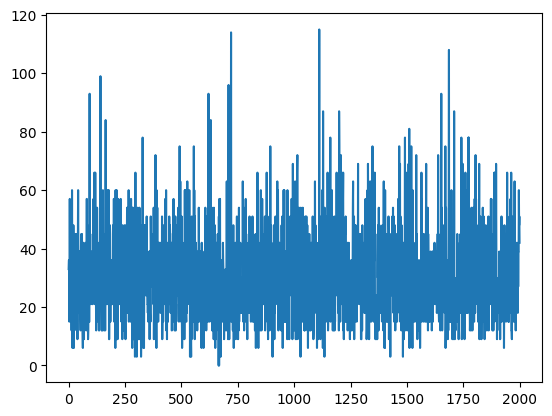

In [27]:
plt.plot(range(2000), total_rewards)

In [29]:
ale = ALEInterface()
ale.loadROM(LostLuggage)
env = gym.make('ALE/LostLuggage-v5')

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import gym

# Определение нейронной сети для аппроксимации стратегии
class Policy(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Policy, self).__init__()
        self.fc = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc(x))
        x = torch.softmax(self.fc2(x), dim=-1)
        return x

# Инициализация среды
ale = ALEInterface()
ale.loadROM(LostLuggage)
env = gym.make('ALE/LostLuggage-v5')
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n

# Инициализация нейронной сети и оптимизатора
policy = Policy(input_dim, output_dim)
optimizer = optim.Adam(policy.parameters(), lr=0.01)

# Функция для обучения агента с помощью REINFORCE
def reinforce(num_episodes):
    for i in range(num_episodes):
        states, rewards, actions = [], [], []
        state = env.reset()
        done = False
        
        while not done:
            action_prob = policy(torch.from_numpy(state).float())
            action = torch.multinomial(action_prob, 1).item()
            next_state, reward, done, _, _ = env.step(action)
            
            states.append(state)
            rewards.append(reward)
            actions.append(action)
            state = next_state
        
        policy_loss = []
        returns = 0
        for t in range(len(rewards)):
            returns = rewards[t] + 0.99 * returns
            policy_loss.append(-torch.log(action_probs[t][actions[t]]) * returns)
        
        optimizer.zero_grad()
        policy_loss = torch.stack(policy_loss).sum()
        policy_loss.backward()
        optimizer.step()

# Обучение агента
reinforce(1000)


TypeError: expected np.ndarray (got tuple)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import gym
import cv2

In [32]:

# Определение сети политики
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, n_actions):
        super(PolicyNetwork, self).__init__()
        self.fc = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, n_actions)
        
    def forward(self, x):
        x = torch.relu(self.fc(x))
        x = self.fc2(x)
        return torch.softmax(x, dim=-1)

# Функция для получения действия на основе вероятностей из сети политики
def get_action(policy_network, state):
    state = torch.FloatTensor(state)
    probs = policy_network(state)
    action = np.random.choice(len(probs), p=probs.data.numpy())
    return action

# Функция обучения с использованием алгоритма REINFORCE
def reinforce(env, n_episodes=1000, max_timesteps=1000, gamma=0.99, lr=0.01):
    state_dim = env.observation_space.shape[0]
    n_actions = env.action_space.n
    
    policy_network = PolicyNetwork(33600, n_actions)
    optimizer = optim.Adam(policy_network.parameters(), lr=lr)
    
    scores = []
    
    for episode in range(1, n_episodes+1):
        state = env.reset()
        log_probs = []
        rewards = []

        state = cv2.cvtColor(cv2.resize(state[0], (210, 160)), cv2.COLOR_BGR2GRAY).flatten().tolist()
        
        for t in range(max_timesteps):
            action = get_action(policy_network, state)
            next_state, reward, done, _, _ = env.step(action)
            
            log_probs.append(torch.log(policy_network(torch.FloatTensor(state))[action]))
            rewards.append(reward)
            
            state = next_state
            
            if done:
                break
        
        scores.append(sum(rewards))
        
        discounts = [gamma**i for i in range(len(rewards))]
        discounted_rewards = [discount * reward for discount, reward in zip(discounts, rewards)]
        
        R = sum(discounted_rewards)
        
        policy_loss = []
        for log_prob, reward in zip(log_probs, discounted_rewards):
            policy_loss.append(-log_prob * R)
        
        optimizer.zero_grad()
        policy_loss = torch.stack(policy_loss).sum()
        policy_loss.backward()
        optimizer.step()
        
        if episode % 100 == 0:
            print("Episode {}, Average Score: {:.2f}".format(episode, np.mean(scores[-100:])))
    
    env.close()


In [33]:
ale = ALEInterface()
ale.loadROM(LostLuggage)
env = gym.make('ALE/LostLuggage-v5')

In [27]:
reinforce(env)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (33600x3 and 33600x64)